# Step 1: Import the required libraries

In [14]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma.core import size
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Step 2: Load and prepare the data

In [15]:
# Starting point : When Bitcoin firstly was showed on Yahoo Finance Chart
# First, I will looking into "S&P500(^GSPC)" Price. After analyzing it, I will apply this metrics to the other investment assets. 

start = "2014-09-17"
end = "2024-02-14"
symbol = {"^GSPC"}
SnP = yf.download(symbol, start, end, auto_adjust=True)
print(SnP)
print()
print(SnP.info())

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close      Volume
Date                                                                      
2014-09-17  1999.300049  2010.739990  1993.290039  2001.569946  3209420000
2014-09-18  2003.069946  2012.339966  2003.069946  2011.359985  3235340000
2014-09-19  2012.739990  2019.260010  2006.589966  2010.400024  4880220000
2014-09-22  2009.079956  2009.079956  1991.010010  1994.290039  3349670000
2014-09-23  1992.780029  1995.410034  1982.770020  1982.770020  3279350000
...                 ...          ...          ...          ...         ...
2024-02-07  4973.049805  4999.890137  4969.049805  4995.060059  4895590000
2024-02-08  4995.160156  5000.399902  4987.089844  4997.910156  4341860000
2024-02-09  5004.169922  5030.060059  5000.339844  5026.609863  3912990000
2024-02-12  5026.830078  5048.390137  5016.830078  5021.839844  3805740000
2024-02-13  4967.939941  4971.299805  4920.310059  4953.169922  4302190000

[2368 rows x 5 columns]


# Step 3: Visualize the data and conduct the ADF test

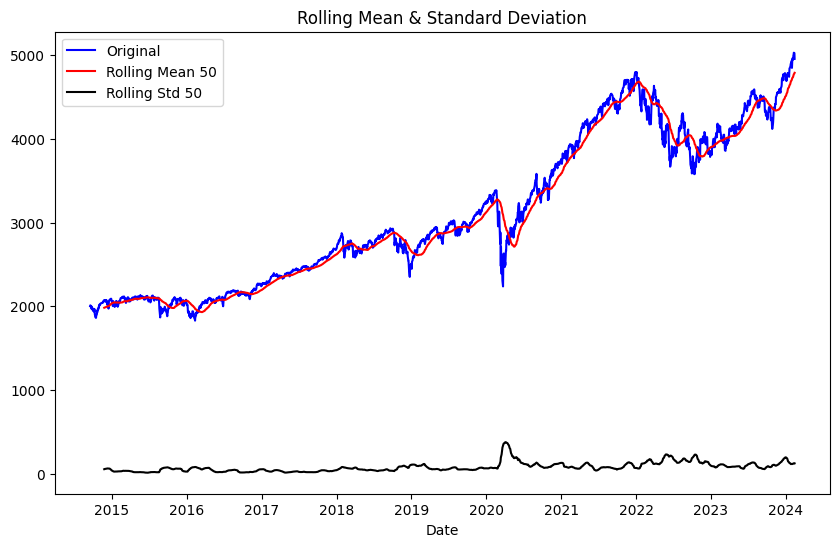

In [16]:
# Data preprocessing
data = SnP['Close']


# Visualizing Original, Rolling Mean, Rolling Std
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean {}'.format(interval))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std {}'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Rolling Mean(50)
plot_rolling(data, 50)

In [17]:
# Perform ADF test

def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST Result')
adf_test(data)

ADF TEST Result
ADF Statistics: -0.223227
p-value: 0.935696
num of lags: 10.000000
num of observations: 2357.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


# Step 4: Time Series Data Decomposition

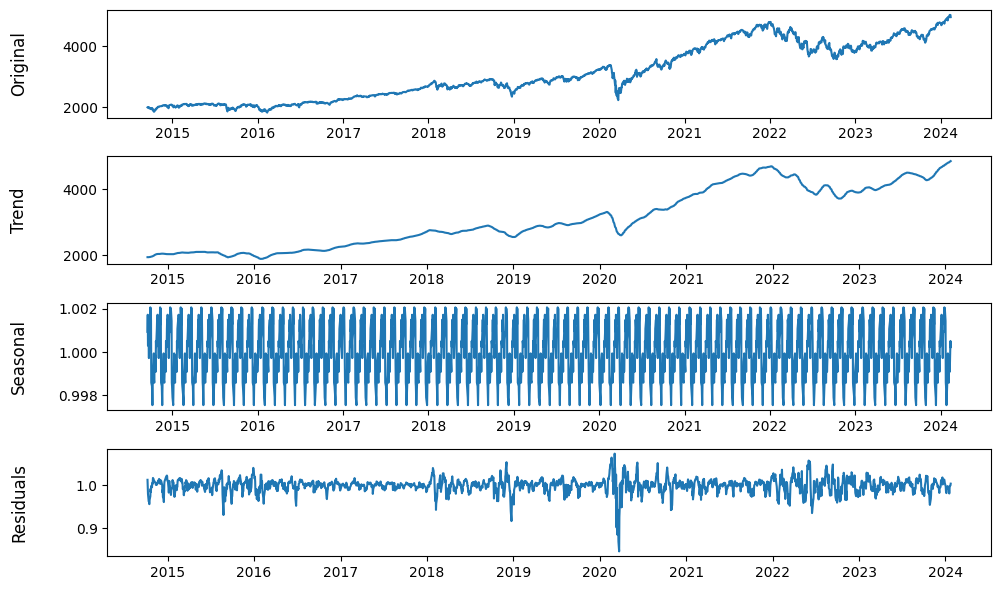

In [18]:
# Perform Time Series Data Decomposition since it helps in understanding the underlying structure and preparing the data for further analysis or modeling.

decomposition = seasonal_decompose(data, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 6))
# Original
plt.subplot(411)
plt.plot(data, label='original')
plt.annotate('Original', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Trend
plt.subplot(412)
plt.plot(trend, label='trend')
plt.annotate('Trend', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Seasonality
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.annotate('Seasonal', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Residuals
plt.subplot(414)
plt.plot(residual, label='residuals')
plt.annotate('Residuals', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

plt.tight_layout()
plt.show()

In [19]:
# Check the trend's staionary after decomposition : No

trend.dropna(inplace=True)
adf_test(trend)

ADF Statistics: 0.447441
p-value: 0.983185
num of lags: 27.000000
num of observations: 2310.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


# Step 5: Converting non-stationary into stationary data

<Axes: xlabel='Date'>

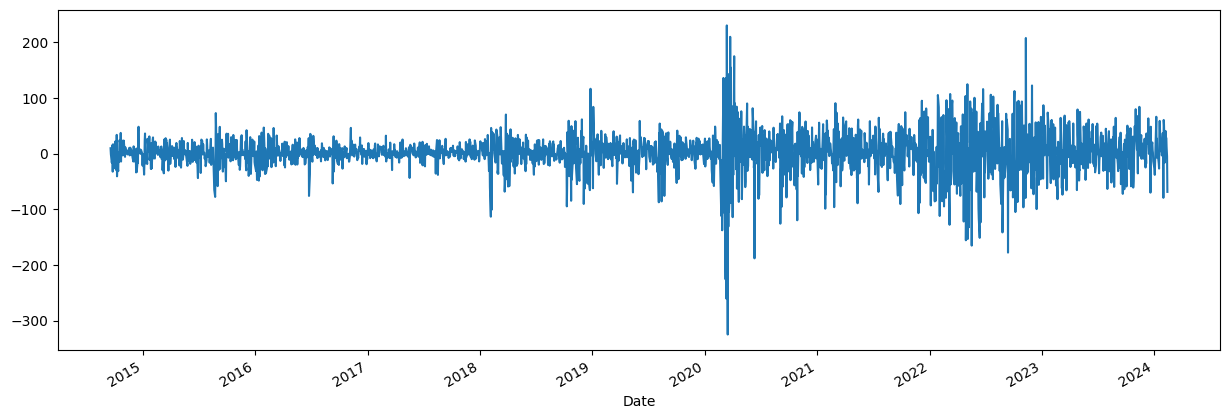

In [20]:
# The is non-stationary, which is evident in the trend itself, but it is always good to verify things. 
# So I need to apply some operations to make the series stationary by differencing

dff1 = data.diff().dropna()
dff1.plot(figsize=(15,5))

In [21]:
# After differencing : Stationary
print('ADF TEST Result')
adf_test(dff1)

ADF TEST Result
ADF Statistics: -15.144828
p-value: 0.000000
num of lags: 9.000000
num of observations: 2357.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


# Step 6: Finding the optimal parameters for ARIMA

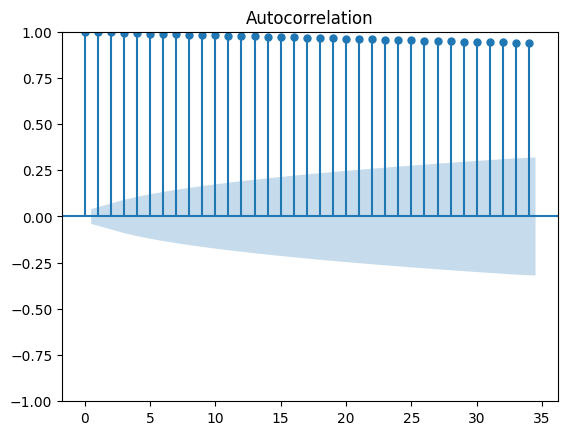

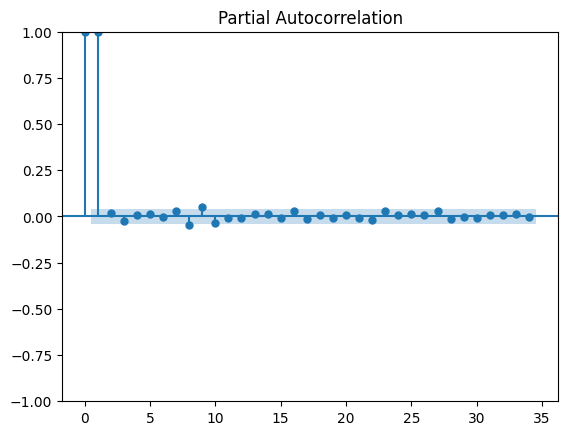

In [22]:
plot_acf(data)
plot_pacf(data)
plt.show()

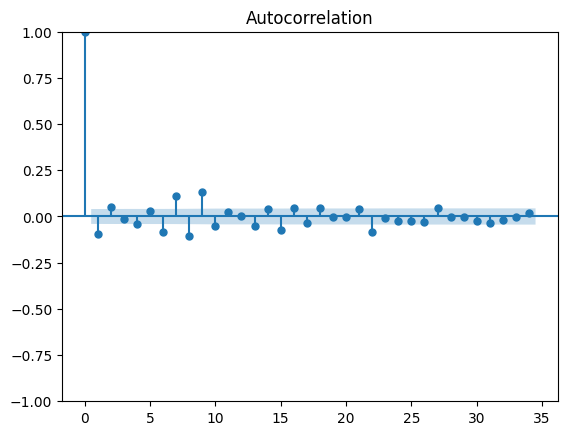

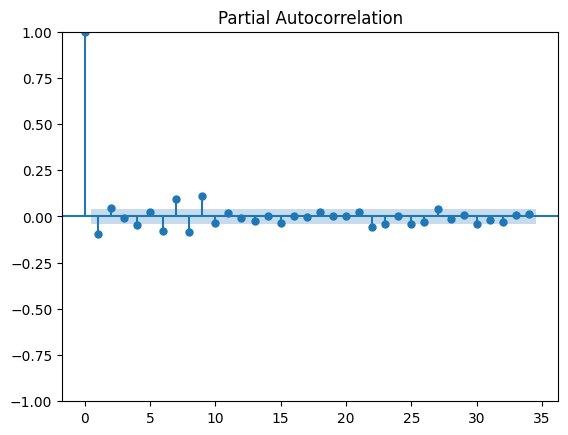

In [23]:
plot_acf(dff1)
plot_pacf(dff1)
plt.show()

In [25]:

from pmdarima.arima import ndiffs

n_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
print(f"Optimal d = {n_diffs}") 


Optimal d = 1


In [26]:
# Using autoarima 

import pmdarima as pm

model_arima = pm.auto_arima(
            y=data, 
            d=1, 
            start_p=0, max_p=3, 
            start_q=0, max_q=3, 
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23704.699, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23685.686, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23687.475, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23705.515, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23683.194, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23685.058, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23685.153, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23684.366, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23685.467, Time=1.74 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=23684.307, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 3.806 seconds


In [27]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2368
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -11837.597
Date:                Thu, 15 Feb 2024   AIC                          23683.194
Time:                        13:32:53   BIC                          23706.271
Sample:                             0   HQIC                         23691.595
                               - 2368                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3031      0.780      1.671      0.095      -0.225       2.832
ar.L1         -0.0900      0.010     -8.589      0.000      -0.110      -0.069
ar.L2          0.0436      0.010      4.437      0.0

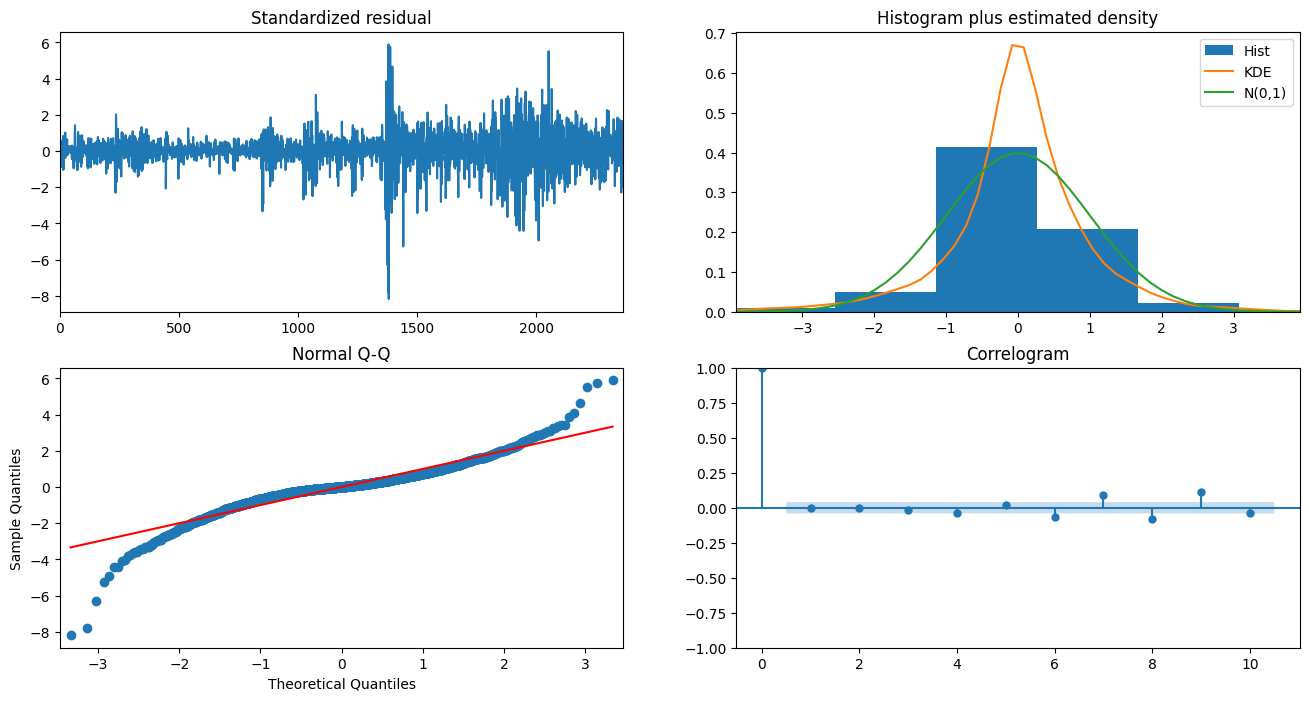

In [28]:
model_arima.plot_diagnostics(figsize=(16,8))
plt.show()

# Step 7: Split Train-Test 

In [29]:
# train, test set분리
# train : test = 8 : 2
train_data, test_data = data[:int(len(data)*0.8)], data[int(len(data)*0.8):]

# train_data 모델 학습
from statsmodels.tsa.arima_model import ARIMA

model_fit_arima = pm.auto_arima(
    	    y=train_data, 
 	        d=n_diffs , 
            start_p=0, max_p=2, 
            start_q=0, max_q=2, 
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)
print(model_fit_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18560.834, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18523.208, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18529.031, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18561.995, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=18513.680, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18515.650, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18517.987, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=18515.258, Time=0.06 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.642 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1894
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -9252.840
Date:                Thu, 15 Feb 2024   AIC                          18513.680
Time:                       

# Step 8: Compare Test/Train

In [30]:
# test_data 와 예측값 비교

# forecast 함수
def forecast_n_step(model_arima, n = 1):
    fc, conf_int = model_arima.predict(n_periods=n, return_conf_int=True)
    # print("fc", fc,"conf_int", conf_int)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model_arima, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc, conf = forecast_n_step(model_arima)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model_arima.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model_arima)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model_arima.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower

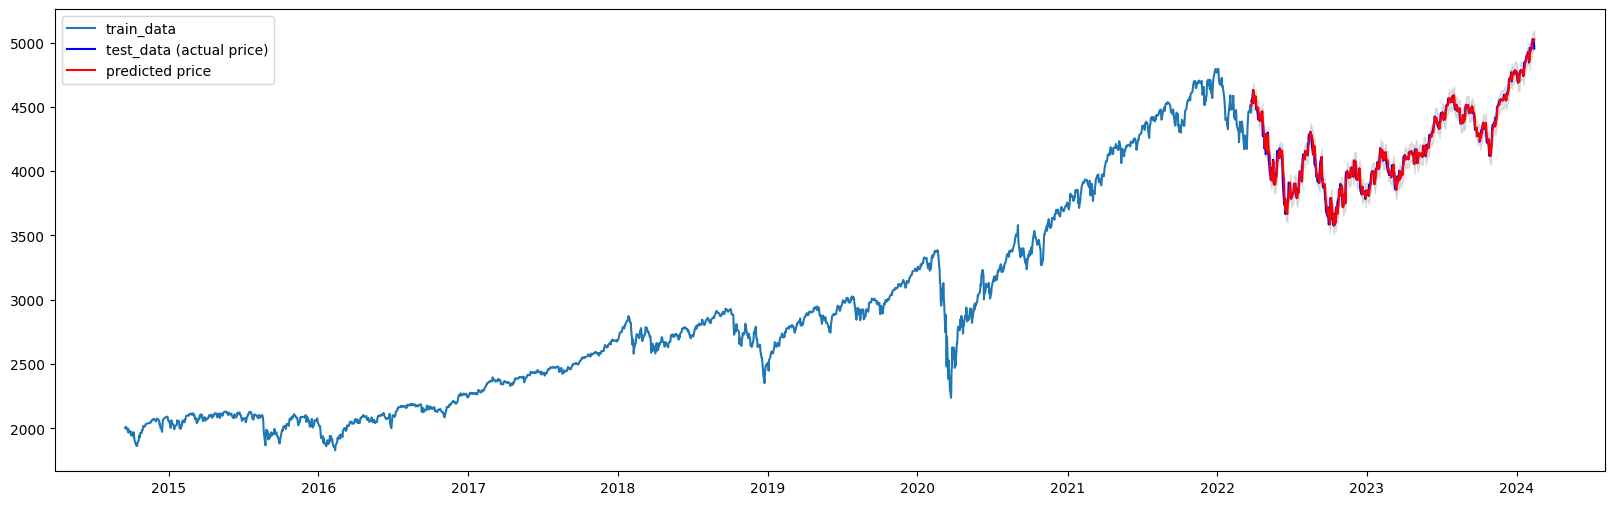

In [31]:
# test_data와 예측값 그래프
# Forecast 

fc, upper, lower = forecast(len(test_data), model_fit_arima, test_data.index, data = test_data)

# pandas series 생성
# fc # 예측결과
lower_series = pd.Series(lower, index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(upper, index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(20,6))
plt.plot(train_data, label='train_data')
plt.plot(test_data, c='b', label='test_data (actual price)')
plt.plot(fc, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend(loc='upper left')
plt.show()

In [32]:
# 모델의 오차율 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 로그 취하기
log_test_data = np.log(test_data)
log_fc = np.log(fc)

mse = mean_squared_error(np.exp(log_test_data), np.exp(log_fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(log_test_data), np.exp(log_fc))
print('MAE: ', mae)
rmse = np.sqrt(mean_squared_error(np.exp(log_test_data), np.exp(log_fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(log_fc) - np.exp(log_test_data))/np.abs(np.exp(log_test_data)))
print('MAPE: ' ,'{:.2f}%'.format(mape*100))
""

MSE:  2344.7069161492054
MAE:  36.65760797066396
RMSE:  48.42217380652386
MAPE:  0.89%


''

# Step 9: Predicting price after 1 year 

In [33]:
# 주식개장일 불러오는 함수 생성
import exchange_calendars as ecals
def get_open_dates(start,end):
    k = ecals.get_calendar("XKRX")
    df = pd.DataFrame(k.schedule.loc[start:end]) 
    # print(df['open'])
    date_list = []
    for i in df['open']:
        date_list.append(i.strftime("%Y-%m-%d"))
       # print(i.strftime("%Y-%m-%d"))   
    date_index = pd.DatetimeIndex(date_list)
    return date_index  # DatetimeIndex


S&P500 Price in 1 year
2025-02-07    5256.704777
2025-02-10    5257.952713
2025-02-11    5259.200715
2025-02-12    5260.448699
2025-02-13    5261.696687
dtype: float64


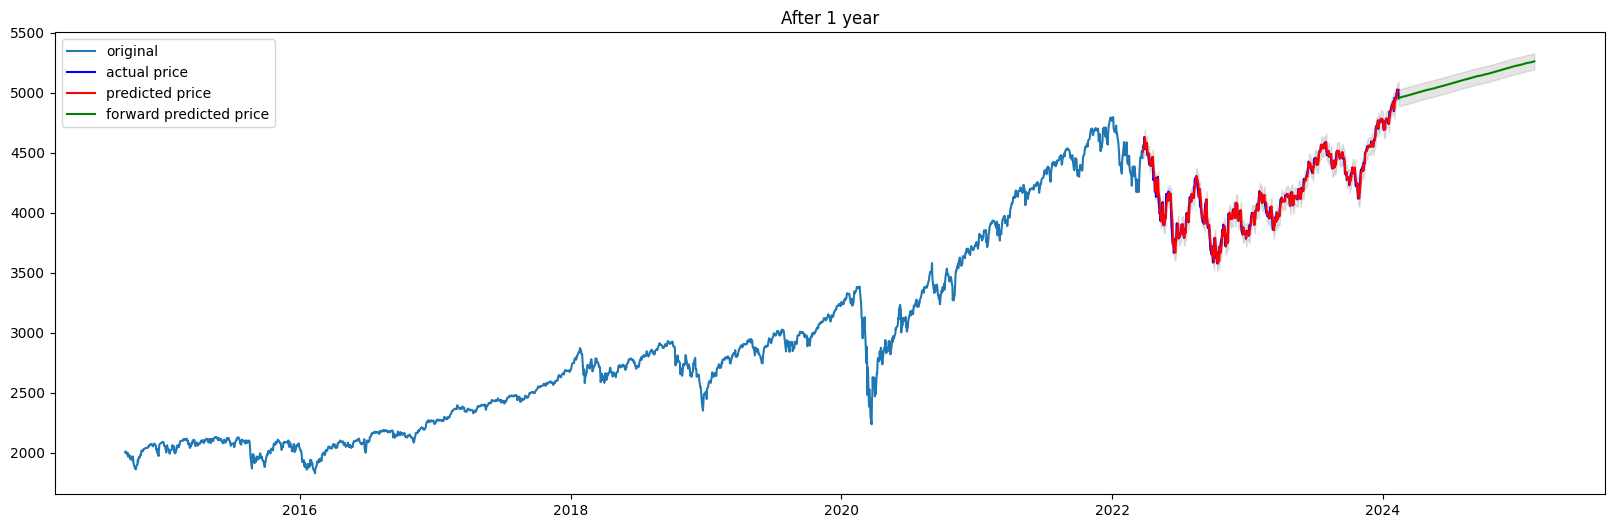

In [34]:
# 향후 1년 주가 예측
date_index = get_open_dates("2024-2-14","2025-2-13")
fc2, upper2, lower2 = forecast(len(date_index), model_fit_arima, date_index)
print('S&P500 Price in 1 year') 
print(fc2.tail())
# fc2, conf = forecast_n_step(model_fit, len(date_list))
lower_series2 = pd.Series(lower2, index=date_index)  # 예측결과의 하한 바운드
upper_series2 = pd.Series(upper2, index=date_index)  # 예측결과의 상한 바운드
# plot
plt.figure(figsize=(20,6))
plt.plot(train_data, label='original')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc, c='r',label='predicted price')
plt.plot(fc2, c='g',label='forward predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.10)
plt.title('After 1 year')
plt.legend(loc='upper left')
plt.show()

In [35]:
# Compare with the Current Price:
current_price = test_data[-1]  # Current stock price (e.g., the last price in the training data)
predicted_price_1_year = fc2[-1]
price_change = predicted_price_1_year - current_price  # Price change
price_change_percent = (price_change / current_price) * 100  # Calculate the percentage increase

print("Current Price:", current_price)
print("Predicted Stock Price for One Year Ahead:", predicted_price_1_year)
print("Price Change:", price_change)
print("Percentage Increase:", price_change_percent, "%")

Current Price: 4953.169921875
Predicted Stock Price for One Year Ahead: 5261.696686504814
Price Change: 308.52676462981435
Percentage Increase: 6.22887503348609 %


# SARIMAX